# The Illustrated Introduction to Neural Networks #

This is an illustrated introduction to neural networks. If you'd like to download it and play with the code yourself, the [source is available on github](https://github.com/wwarner/jupyter). It includes a Dockerfile so that it's pretty easy to start the jupyter server with "batteries included".

## Linear Regression In Terms of Gradient Descent ##

When we look at a bunch of observations scattered across the XY plane, we often want to know if there is a linear relationship between $x$ and $y$.

As long as we have a way to calculate the error of any given linear approximation, we can approach this problem in any number of ways. We could actually draw 100 lines at random and pick the best fit (the Monte Carlo method). With a little calculus, we can develop a closed form solution. Here we're going to use the same analysis of the closed form solution to develop a more general approximation approach called __Gradient Descent__.

Here are some points randomly distributed about a line. All the figures that follow are based on these values.

In [21]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation, rc
from IPython.display import HTML

# google colab wants this...
# !pip install git+git://github.com/mkrphys/ipython-tikzmagic.git
import tikzmagic
%load_ext tikzmagic
%matplotlib inline

In [2]:
#@title
# x from 0 to 30
x = np.random.random((30, 1))
real_m = 10*(0.5-np.random.rand())
real_b = 10*(0.5-np.random.rand())
# y = a*x + b with noise
y = (real_m * x) + real_b + np.random.normal(size=x.shape,scale=0.5*abs(real_b))

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
sc = StandardScaler()
x = sc.fit_transform(x)
y = sc.fit_transform(y)

<Figure size 288x216 with 0 Axes>

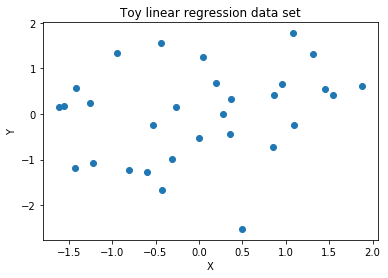

In [3]:
#@title
plt.figure(figsize=(4, 3))
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set(xlabel='X', ylabel='Y', title='Toy linear regression data set');

## The Loss Function ##

We want to find the line that fits the observations most closely. In other words, we want the function $\hat{y}=f(x)$ that minimizes the error. Or, in the language of machine learning, we minimize the __Loss Function__

$\mathscr{L}=\frac{1}{n}\sum(y-\hat{y})$

where the $y$s are our observed values and the $\hat{y}$s are our predictions, and $n$ is the number of observations.

For any prediction problem, we'll define a function that produces predictions and minimize the error.

In the case of linear regression, we are only interested in straight lines.

$\hat{y}=mx+b$

We want to find the values for $m$ and $b$ that minimize the error. In terms of the loss function:

$\mathscr{L}(m,b)=\frac{1}{n}\sum| y-mx-b |$

We'll plot $\mathscr{L}$ as a function of $m$ and $b$. 

In [4]:
def ℒ(m, b):
    e = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        yhat = m*x[i]+b
        e += abs(y[i]-yhat)
    return e/len(x)

In [5]:
%%capture
view_distance=10.0
m = np.linspace(real_m-real_m*view_distance, real_m+real_m*view_distance, 30)
b = np.linspace(real_b-real_b*view_distance, real_b+real_b*view_distance, 30)

M, B = np.meshgrid(m, b)

E = ℒ(M, B)

fig2 = plt.figure(figsize=(20,10))
ax2 = fig2.add_subplot(1, 1, 1, projection='3d')

def init():
    ax2.view_init(20,0)
    ax2.plot_surface(M, B, E,cmap='RdBu')
    ax2.set_xlabel('m (slope)')
    ax2.set_ylabel('b (intercept)')
    ax2.set_zlabel('ℒ (error)')
    fig2.suptitle("ℒ as a function of m and b\nPress the play button to see the surface", fontsize=20)
    return fig2,

def animate(i):
    ax2.view_init(20,12*i)
    return fig2,

ani = animation.FuncAnimation(fig2, animate, init_func=init,
                               frames=30, interval=200, blit=True)

In [6]:
HTML(ani.to_jshtml())

We've plotted the loss function $\mathscr{L}$ on the vertical axis and slope ($m$) and intercept ($b$) on the x and y axes.

We want the values of $m$ and $b$ that yield the lowest error. If we were walking on this surface, we'd know exactly how to get to the bottom: no matter where we are, just follow the path of steepest descent. This is the intuition of gradient descent.

We compute the tangent plane at the point we're currently at, and then we find the arrow in that plane that points most steeply downward. And the tangent plane is the derivative of the loss function at that point.

### Differentiation ###

There is a bit of calculus that makes gradient descent in a high dimensional space with many neurons a tractable computation.

We know that our loss function $\mathscr{L}$ defines a surface. As long as we can say that at any point on that surface we can define a tangent plane and compute the direction of steepest descent, we can perform gradient descent.

The tanget plane at any given point is the derivative, so we make sure that $\mathscr{L}$ is differentiable at every point. 

Thinking again of our two dimensional linear case, and using mean squared error for our loss function:

$\mathscr{L}(m,b)=\frac{1}{n}\sum(y-mx-b)^2$

then

$\frac{\partial{\mathscr{L}}}{\partial{m}} = \frac{2}{n}\sum(y - mx -b)x$

and

$\frac{\partial{\mathscr{L}}}{\partial{b}} = \frac{2}{n}\sum(y - mx -b)$

Those two expressions allow the alogorithm to know how to descend the parabolic shape in the example above. For any point ($m$, $b$), we have two tangent lines that define the tangent plane.

### The Chain Rule ###

Neural networks are just nested function calls (as we'll see in the next section). We use the chain rule to compute the derivative of the function defined by the entire network.

Recall the chain rule:

Given: $\mathscr{L}(x)=f(g(x))$

then $\mathscr{L}'(x) = f'(g(x)) \cdot g'(x)$

We can compute the derivative of any number of nested function calls as long as each constituent function is differentiable.

## Neural Networks ##

In a neural network, we employ the strategy of gradient descent, but now our prediction function is going to be a combination functions, and we're going to allow the number of dimensions to go up.

### Neurons ###

Each node in a neural network is called a neuron, and it *always* has this form: $activation(inputs \cdot kernel + bias)$

Here $activation()$ is a function, inputs are the observations and kernel is directly analagous to the slope $m$ we saw earlier and $bias$ is directly analagous to the intercept $b$.

Let's break this down, starting with $inputs \cdot kernel$.

Say we're interested in movie reviews and given the text of a particular review we want to predict the numeric rating the reviewer gave the movie. And to keep the focus on explaining neurons and neural networks, let's further assume that all the words used in all movie reviews come from a dictionary of 5,000 words.

Now, let's pick a maximum number of words per reivew we'll consider, say 50. We'll just truncate every review to 50 words. With that, we can start to imagine what our input could look like. Each review is a vector of 50 words, and each word is a *one hot* vector of length 5,000. So each one of our observations is an array of size 50 by 5,000, and each observation is associated with an output, an number between 0 and 1. We think of the input as a vector in a space with dimensions (50, 5000). We also think of our output as a vector, with shape (1). We'll denote our input as $\mathbf{x}$, and our output number as $\mathbf{y}$.

The *kernel* is a matrix of weights we multiply our inputs by. It doesn't matter much whether you're familiar with linear algebra here, what's important is that it's exactly the same idea as multiplying by *m* in the two dimensional example above.

The *bias* is similar. It's a vector that we can add to the product coming out of the kernel, just as we added $b$ to $m \cdot x$ in the linear example.

With the concept of vectors, let's denote the *kernel* with $\mathbf{W}$, and *bias* with $\mathbf{b}$.

Brushing aside the activation function for now, our neuron is fully specified by $\mathbf{W}$ and $\mathbf{b}$.

The neuron is a function that multiplies two arrays and adds the bias. In vector notation:

$\hat{\mathbf{y}} = f(\mathbf{x}) = \mathbf{W}\mathbf{x} + \mathbf{b}$

And we can define a loss function as well:

$\hat{\mathbf{y}} = \mathscr{L}(\mathbf{W}, \mathbf{b})=\frac{1}{n}\sum| \mathbf{y} - \mathbf{W}\mathbf{x} - \mathbf{b} |$

Just as before, we can use the loss function to define a convex surface and use gradient descent to find the minimum. We can't draw it, and in fact we can no longer be sure that every local minimum is the global minimun we seek, but conceptually the picture is exactly the same.

### Networks of Neurons ###

So far, we've been working with a single neuron, but we can compose as many neurons as we want to form a network.

For example, this is how we'd work through a network of two neurons.

$\hat{\mathbf{y}} = \mathbf{f_2}(\mathbf{f_1}(\mathbf{x}))$

$\hat{\mathbf{y}} = \mathbf{W}_2 \cdot (\mathbf{W}_1\mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2$

And the loss:

$\mathscr{L}(\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2) = \frac{1}{n}\sum (\mathbf{y} - (\mathbf{W}_2 \cdot (\mathbf{W}_1\mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2) )^2$

This forms a two neuron network $\mathbf{W}_1$ -> $\mathbf{W}_2$

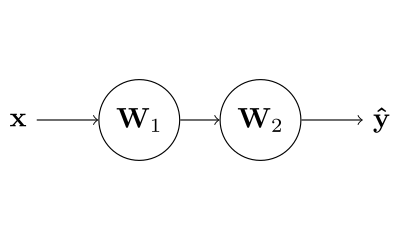

In [7]:
%%tikz -f svg
\node (x) at (0,0) {$\mathbf{x}$};
\node[circle,draw, minimum size=1cm] (W1) at  (1.5,0) {$\mathbf{W}_1$};
\node[circle,draw, minimum size=1cm] (W2) at  (3.0,0) {$\mathbf{W}_2$};
\node (yhat) at (4.5,0) {$\mathbf{\hat{y}}$};
\draw[->] (x) -- (W1);
\draw[->] (W1) -- (W2);
\draw[->] (W2) -- (yhat);

## Example: Deep Learning Linear Regression ##

Finally, we're ready to find the straight line that best fits the data. To find a straight line, we need just a single neuron. In the code below, the neuron is declared with `Dense()`.

In [8]:
%%capture
from keras.layers import Input, Dense
from keras.models import Model, Sequential
import keras as K

In [9]:
%%capture
inputs = Input(shape=(1,))
preds = Dense(1, activation='linear')(inputs)
model = Model(inputs=inputs,outputs=preds)

In [10]:
%%capture
model.compile(optimizer='sgd' ,loss='mse')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%capture

plt.figure(figsize=(4, 3))
fig3, ax3 = plt.subplots()

def init():
    ax3.scatter(x,y)
    ax3.set(xlabel='X', ylabel='Y', title="The same toy linear regression data set\nPress the play button to see how the model learned");
    return fig3,

epochs=10
colors = plt.cm.Greys(np.linspace(0, 1, epochs))
predictions = []
for i in range(epochs):
    model.fit(x,y, batch_size=1, verbose=0, epochs=1, shuffle=False)
    predictions.append(model.predict(x))

def animate(i):
    ax3.plot(x,predictions[i], color=colors[i], linewidth=3)
    return fig3,

ani3 = animation.FuncAnimation(fig3, animate, init_func=init,
                               frames=epochs, interval=200, blit=True)

In [13]:
#@title
HTML(ani3.to_jshtml())

## The Activation Layer ##

The complete definition of a neuron is $activation(inputs \cdot kernel + bias)$. Up til now, we've ignored the activation layer, and just employed compositions of linear functions. It turns out that linear functions cannot fit to lots of machine learning problems. To address the issue, a non-linear, but still differentiable activation function surrounds the linear kernel function.

It's best illustrated with an example.

In [14]:
#@title
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [15]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=500)

In [16]:
#@title
X = scale(X)

In [17]:
#@title
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

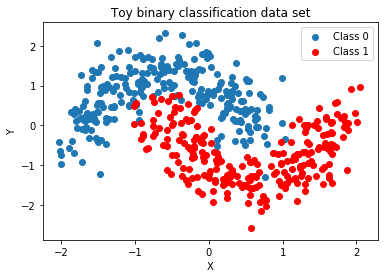

In [18]:
#@title
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

We'll build two models, identical in every way except for the activation function used in the hidden layer. After training them, we display the results side by side. Notice how the `linear` activation function can only find a straight line, wheras the the `relu` model can find a curve taht does a better job of separating the blue and the red points.

In [19]:
%%capture
models = {}
for activation_type in ['linear', 'relu']: # two activation functions
    model = models[activation_type] = Sequential()
    model.add(Dense(128, input_dim=2,activation=activation_type)) # apply the activation function
    model.add(Dense(1, activation='sigmoid')) #binary classification so one output

    model.compile(optimizer='AdaDelta',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    model.fit(X_train, Y_train, batch_size=32, epochs=200,
              verbose=0, validation_data=(X_test, Y_test))
    loss, acc = model.evaluate(X_test, Y_test)
    print("Loss: %4.2f Accuracy: %5.2f" % (loss, acc))

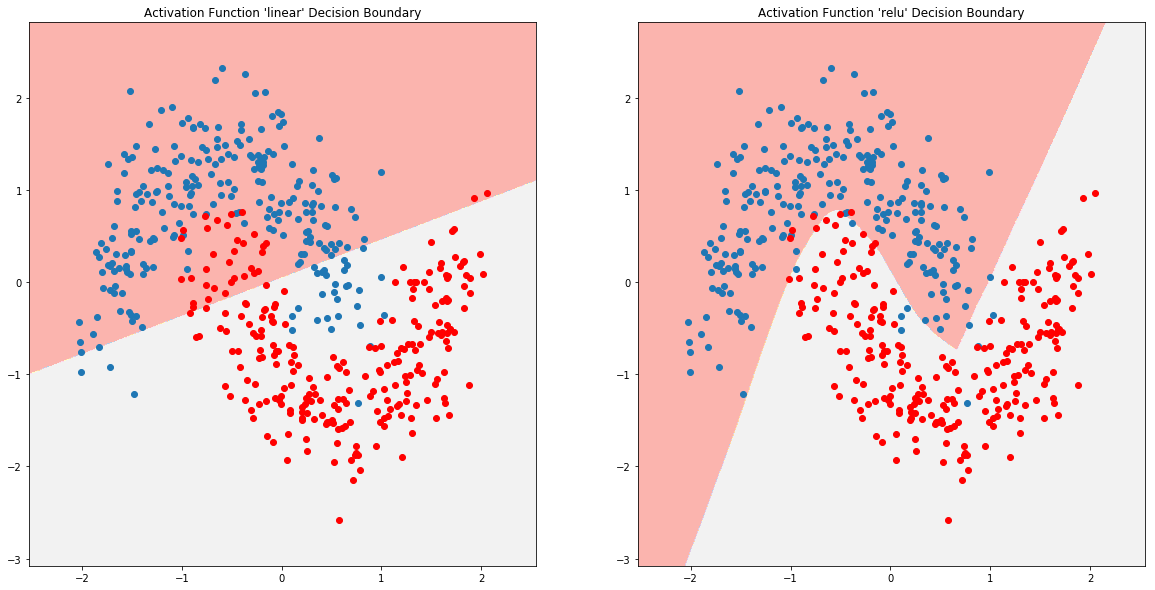

In [20]:
def plot_decision_boundary(pred_func, ax):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')

fig = plt.figure(figsize=(20,10))
for i, activation_type in enumerate(['linear', 'relu']):
    axis = fig.add_subplot(1, 2, i+1)
    plot_decision_boundary(lambda x: models[activation_type].predict_classes(x, batch_size=32), axis)
    t = "Activation Function '%s' Decision Boundary" % activation_type
    axis.title.set_text(t)
